In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer # for bag of words
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.model_selection import GridSearchCV # for grid search
from sklearn.naive_bayes import MultinomialNB # this is the model we will be using
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score # for model evaluation
from sklearn.metrics import confusion_matrix # for model evalutation
# for visualization
import plotly.express as px, plotly.graph_objects as go 
import matplotlib.pyplot as plt

In [5]:
data = pd.read_table('human_data.txt')

In [6]:
data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [7]:
data['class'].value_counts()

class
6    1343
4     711
3     672
1     534
0     531
2     349
5     240
Name: count, dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  4380 non-null   object
 1   class     4380 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 68.6+ KB


In [9]:
# The following function is used to generate all the possible subsequences (or k-mers) of a given length from a larger sequence. 
#sequence[x:x+size] is a slice operation that gets a part of the sequence starting from index x and edning at x+size, this will be a subsequence of length 'size'.
#.lower() is used to convert the subsequence to lower case. 
# for x in range(len(sequence) - size + 1) this is a loop that goes over each possible starting position for a subsequence of length 'size'. This ensures that the last subsequence will end at the end of the sequence. 
def get_kmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [10]:
#The following code applies the get_kmers function to the sequence column of the data.
#lambda x: get_kmers(x['sequence'], 6) is a lambda function that takes a row of the df as input, extracts the sequence column from the row, and passes it to the get_kmers function along with the size of 6. 
#axis=1 is a parameter that tells the apply function to pass the sequence column as a series of characters to the lambda function.
#The result of the apply function is a new column called 'words' that contains a list of all the 6-mers in the sequence column.
data['words'] = data.apply(lambda x: get_kmers(x['sequence'], 6), axis=1)
data = data.drop('sequence', axis=1)

In [11]:
data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


In [12]:
data_text = list(data['words']) #creates a list from the words column. 
for item in range(len(data_text)): #iterates over the list of words
    data_text[item] = ' '.join(data_text[item]) #joins the list of words into a single string where the words are separated by spaces. 
y_data = data.iloc[:, 0].values # extracts the values of the first column of the df, so separates the class into the target variable 


In [13]:
y_data

array([4, 4, 3, ..., 6, 6, 6])

In [14]:
#This code is transforming the input data into a matrix of 4-mers.
count_vect = CountVectorizer(ngram_range=(4,4)) #initializes the count vectorizer object with a parameter that tells it to create a feature for each 4-mer.
X_data = count_vect.fit_transform(data_text) #fits the count vectorizer to the data and then transforms the data into a feature matrix.


In [15]:
print(f'There are {X_data.shape[0]} samples and {X_data.shape[1]} features.') #prints the number of samples and features in the feature matrix.
#there are 4380 samples and 232414 features.

There are 4380 samples and 232414 features.


In [16]:
class_count = data['class'].value_counts().sort_index()
fig = px.bar(x=class_count.index, y = class_count.values, labels={'x':'Class', 'y':'Count'})
fig.show()

In [17]:
#splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 42, stratify = y_data)

In [18]:
print(f'The training set contains {X_train.shape[0]} samples and the testing set contains {X_test.shape[0]} samples.')

The training set contains 3504 samples and the testing set contains 876 samples.


In [19]:
parametes = {'alpha': [0.1, 0.5, 1, 10]}
best_model = GridSearchCV(MultinomialNB(), parametes)
best_model.fit(X_train, y_train)

print(f'The best model has the following parameters: {best_model.best_params_} and the best score is {best_model.best_score_}')

The best model has the following parameters: {'alpha': 0.5} and the best score is 0.9628979009578155


In [20]:
# Multinomial Naive Bayes is a type of Naive Bayes that is used for discrete data. In this case, the features are the counts of 4-mers in the sequences, so the data is discrete. 
model = MultinomialNB(alpha=0.5) #initializes the model with a smoothing parameter of 0.1
model.fit(X_train, y_train) #fits the model to the training data

MultinomialNB(alpha=0.5)

In [21]:
y_pred = model.predict(X_test) #predicts the classes of the testing data 

In [22]:
len(y_pred)

876

In [24]:
def get_matrix(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average = 'weighted')
    recall = recall_score(y_test, y_pred, average = 'weighted')
    f1 = f1_score(y_test, y_pred, average = 'weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_matrix(y_test, y_pred)

print(f'The accuracy of this model is {accuracy: .2f}, the precision is {precision: .2f}, the recall score is {recall: .2f} and the f1 score is {f1: .2f}')

The accuracy of this model is  0.98, the precision is  0.98, the recall score is  0.98 and the f1 score is  0.98


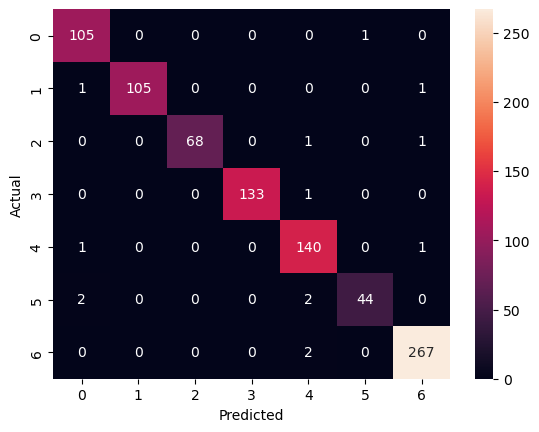

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()